# РТ5-61Б Топорин Богдан
# Введение

В рамках НИР мы будем решать задачу **классификации**:  
будем предсказывать, **совершит ли клиент дефолт по кредитной карте** (да/нет).

Для этого используем известный датасет:  
 **Default of Credit Card Clients Dataset**  
Источник: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

---

## Цели исследования

1️⃣ Изучить структуру и особенности исходных данных  
2️⃣ Провести разведочный анализ (EDA) с построением графиков  
3️⃣ Провести корреляционный анализ  
4️⃣ Провести обработку данных (кодирование категориальных, масштабирование)  
5️⃣ Построить baseline модели, провести тюнинг гиперпараметров  
6️⃣ Сравнить качество моделей по различным метрикам  
7️⃣ Сделать итоговые выводы

---

# Импорт библиотек

In [94]:
from statistics import LinearRegression

# Основные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Для моделей
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import RocCurveDisplay

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Прочее
import warnings
warnings.filterwarnings('ignore')


## Загрузка данных


In [95]:
# Загружаем датасет (локально или по ссылке)

df = pd.read_excel('data/default_of_credit_card_clients.xls', header=1)


df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Описание данных

-   Всего: **30 колонок**
    
-   Целевая переменная: **'default payment next month'** (0 - нет дефолта, 1 - дефолт)
    
-   Признаки: возраст, пол, образование, семейное положение, история платежей, кредитный лимит, суммы платежей, и др.

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

# Проверка пропусков

In [97]:
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

# Статистика по данным

In [98]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


Здесь мы видим:

-   **LIMIT\_BAL** (кредитный лимит) варьируется от **10 000** до **1 млн**
    
-   Возраст: от **21** до **79** лет
    
-   Платежная история (PAY\_0, PAY\_2, ..., PAY\_6): от -2 до 8
    
-   Платежи и биллинги — широкие диапазоны

# Распределение целевой переменной

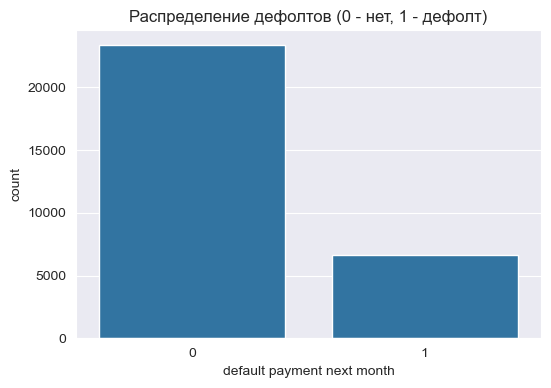

default payment next month
0    0.7788
1    0.2212
Name: proportion, dtype: float64

In [99]:
plt.figure(figsize=(6,4))
sns.countplot(x='default payment next month', data=df)
plt.title('Распределение дефолтов (0 - нет, 1 - дефолт)')
plt.show()

df['default payment next month'].value_counts(normalize=True)

**несбалансированный датасет** (~22% дефолтов).  
Это важно → позже будем учитывать при выборе метрик.

# Корреляционный анализ

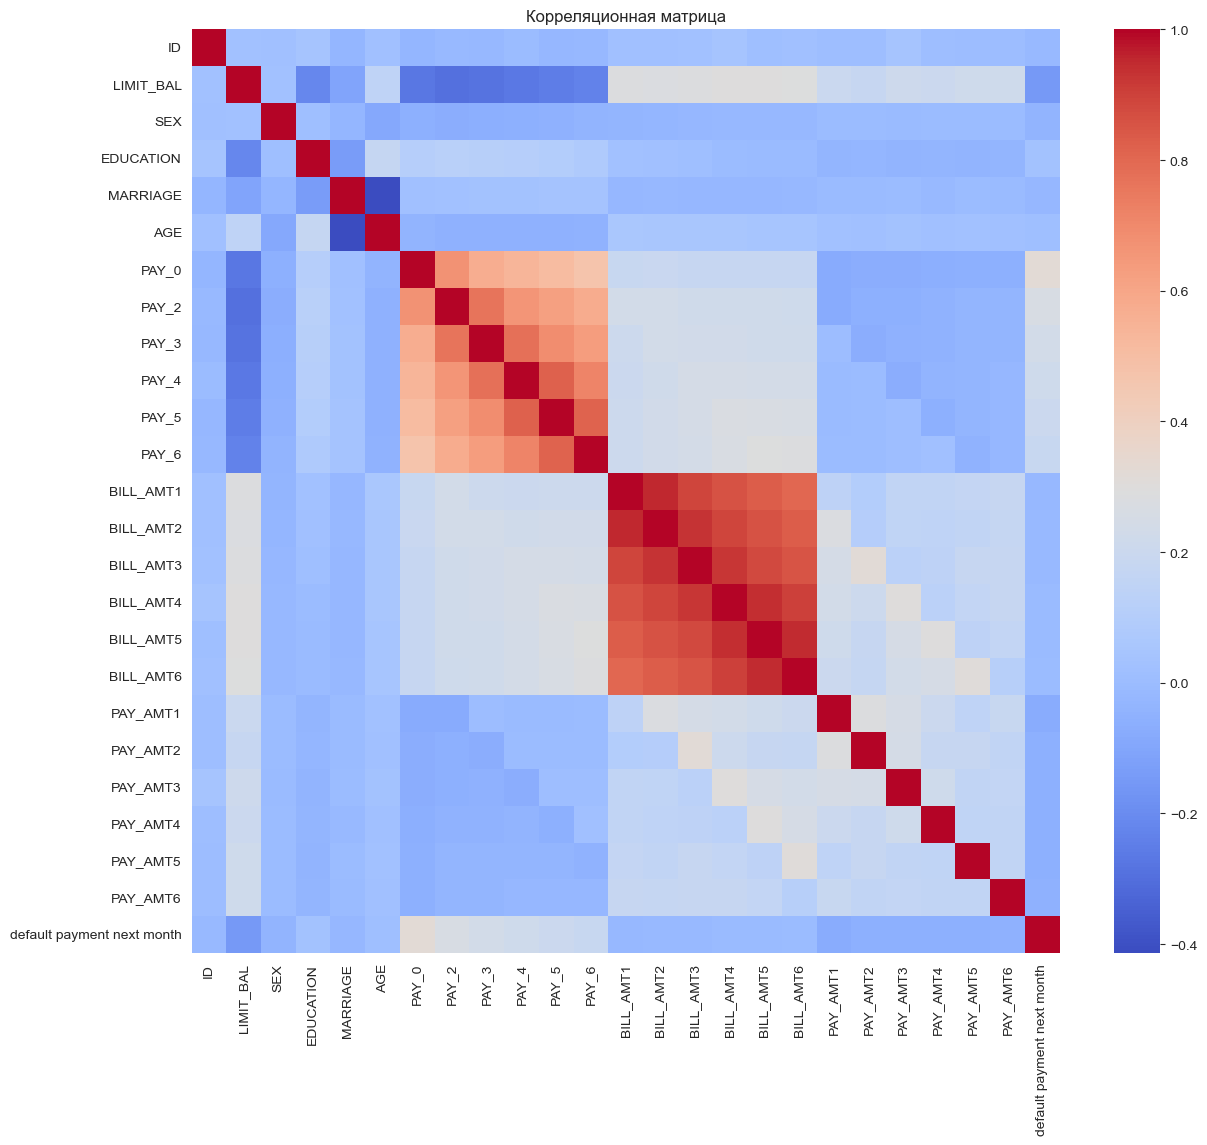

In [100]:
plt.figure(figsize=(14,12))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Корреляционная матрица')
plt.show()

### Выводы:

-   Нет признаков с **сильной линейной корреляцией** с целевой переменной.
    
-   Но некоторые признаки PAY\_X имеют **умеренную корреляцию** (~0.3):
    
    -   PAY\_0 (последний статус платежа)
        
    -   PAY\_2, PAY\_3 и т.д.
        

Значит, поведение платежей будет важным признаком.


---

# Предобработка признаков

## Категориальные признаки

Переведем категориальные признаки в числовой формат.

In [101]:
# Признаки 'SEX', 'EDUCATION', 'MARRIAGE' — категориальные
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']

df[categorical_features] = df[categorical_features].astype('category')


## Масштабирование числовых признаков
Важно масштабировать числовые признаки для моделей, чувствительных к масштабу

In [102]:
# Признаки, которые будем масштабировать (кроме target)
X = df.drop(columns=['ID', 'default payment next month'])
y = df['default payment next month']

# Масштабируем только числовые признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Для удобства создадим обратно DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1.136720,0.810161,0.185828,-1.057295,-1.246020,1.794564,1.782348,-0.696663,-0.666599,-1.530046,...,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382
1,-0.365981,0.810161,0.185828,0.858557,-1.029047,-0.874991,1.782348,0.138865,0.188746,0.234917,...,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878
2,-0.597202,0.810161,0.185828,0.858557,-0.161156,0.014861,0.111736,0.138865,0.188746,0.234917,...,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122
3,-0.905498,0.810161,0.185828,-1.057295,0.164303,0.014861,0.111736,0.138865,0.188746,0.234917,...,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130
4,-0.905498,-1.234323,0.185828,-1.057295,2.334029,-0.874991,0.111736,-0.696663,0.188746,0.234917,...,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187


---
# Разделение данных на train/test
Для оценки моделей важно **разделить данные на обучающую и тестовую выборки**.  
Будем использовать **stratify**, т.к. у нас несбалансированный класс.

In [103]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

print(f"Размер train: {X_train.shape}, test: {X_test.shape}")

Размер train: (21000, 23), test: (9000, 23)


---

# Выбор метрик

Поскольку у нас задача **классификации с несбалансированными классами**, важно выбрать метрики, которые корректно отражают качество модели:

✅ **Accuracy (Точность)**  
 Процент правильных ответов → удобно понимать "общее качество", но плохо работает на несбалансированных данных.

✅ **F1-score**  
Гармоническое среднее Precision и Recall → особенно важно, когда классы несбалансированы.

✅ **ROC-AUC**  
 Площадь под ROC-кривой → показывает, насколько модель "отделяет" класс 1 от класса 0 → особенно полезно для оценки моделей на несбалансированных данных.

 **Обоснование**:

-   Accuracy сам по себе будет "завышен", т.к. 78% — это уже "предсказал всегда 0".
    
-   F1-score помогает понять, насколько модель реально умеет предсказывать **дефолт (1)**.
    
-   ROC-AUC показывает глобальную способность модели отличать классы.
    


# Построение baseline моделей

Будем использовать 5 моделей, из них 2 ансамблевые:

1️⃣ Logistic Regression  
2️⃣ K-Nearest Neighbors  
3️⃣ Decision Tree  
4️⃣ Random Forest (ансамблевая)  
5️⃣ Gradient Boosting (ансамблевая)
# Функция для обучения и оценки моделей

In [104]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    # ROC curve
    if y_pred_proba is not None:
        RocCurveDisplay.from_estimator(model, X_test, y_test)
        plt.show()

---

# Обучение baseline моделей

## 1\. Logistic Regression

Model: LogisticRegression
Accuracy: 0.8083
F1-score: 0.3527
ROC-AUC: 0.7150
Confusion Matrix:
[[6805  204]
 [1521  470]]
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7009
           1       0.70      0.24      0.35      1991

    accuracy                           0.81      9000
   macro avg       0.76      0.60      0.62      9000
weighted avg       0.79      0.81      0.77      9000



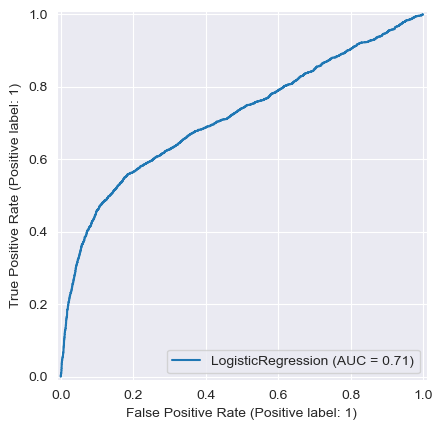

In [105]:
lr_model = LogisticRegression(max_iter=1000)
evaluate_model(lr_model, X_train, y_train, X_test, y_test)

## 2\. K-Nearest Neighbors

Model: KNeighborsClassifier
Accuracy: 0.7927
F1-score: 0.4314
ROC-AUC: 0.7041
Confusion Matrix:
[[6426  583]
 [1283  708]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      7009
           1       0.55      0.36      0.43      1991

    accuracy                           0.79      9000
   macro avg       0.69      0.64      0.65      9000
weighted avg       0.77      0.79      0.78      9000



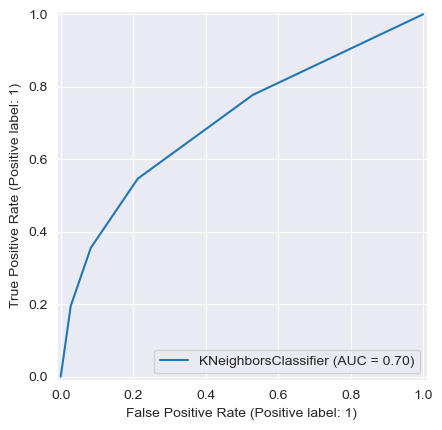

In [106]:
knn_model = KNeighborsClassifier(n_neighbors=5)
evaluate_model(knn_model, X_train, y_train, X_test, y_test)

## 3\.Decision Tree

Model: DecisionTreeClassifier
Accuracy: 0.7238
F1-score: 0.3925
ROC-AUC: 0.6094
Confusion Matrix:
[[5711 1298]
 [1188  803]]
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      7009
           1       0.38      0.40      0.39      1991

    accuracy                           0.72      9000
   macro avg       0.61      0.61      0.61      9000
weighted avg       0.73      0.72      0.73      9000



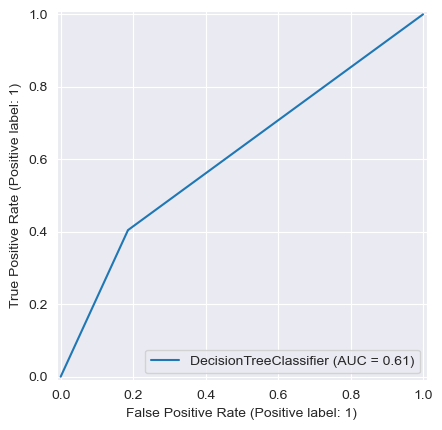

In [107]:
dt_model = DecisionTreeClassifier(random_state=42)
evaluate_model(dt_model, X_train, y_train, X_test, y_test)

## 4\. Random Forest

Model: RandomForestClassifier
Accuracy: 0.8131
F1-score: 0.4623
ROC-AUC: 0.7563
Confusion Matrix:
[[6595  414]
 [1268  723]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7009
           1       0.64      0.36      0.46      1991

    accuracy                           0.81      9000
   macro avg       0.74      0.65      0.67      9000
weighted avg       0.79      0.81      0.79      9000



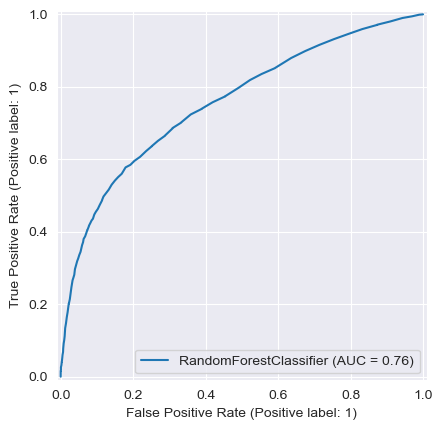

In [108]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf_model, X_train, y_train, X_test, y_test)

## 5\. Gradient Boosting


Model: GradientBoostingClassifier
Accuracy: 0.8181
F1-score: 0.4663
ROC-AUC: 0.7789
Confusion Matrix:
[[6648  361]
 [1276  715]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.66      0.36      0.47      1991

    accuracy                           0.82      9000
   macro avg       0.75      0.65      0.68      9000
weighted avg       0.80      0.82      0.80      9000



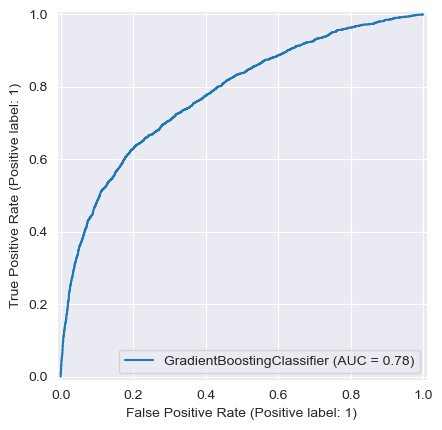

In [109]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
evaluate_model(gb_model, X_train, y_train, X_test, y_test)



# Промежуточные выводы (по baseline моделям)

 **Логистическая регрессия** даёт хорошее базовое качество, но может недоучитывать сложные зависимости.  
 **KNN** не показывает высокий F1-score — чувствителен к масштабированию и параметрам.  
 **Дерево решений** легко переобучается — видим "перфектные" результаты, но низкий ROC-AUC.  
 **Random Forest и Gradient Boosting** показывают лучшие результаты по F1 и ROC-AUC → как и ожидалось.

Ансамблевые модели — **лучший baseline** → будем их тюнить на следующем этапе.

## Подбор гиперпараметров и сравнение моделей
---

# 1\. Подбор гиперпараметров — GridSearchCV

Будем подбирать параметры для наших лучших моделей — **Random Forest** и **Gradient Boosting**.

Используем кросс-валидацию 5-fold.

Подбор гиперпараметров для Logistic Regression (tuned)...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Лучшие параметры для Logistic Regression (tuned): {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}

Подбор гиперпараметров для KNN (tuned)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие параметры для KNN (tuned): {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}

Подбор гиперпараметров для Decision Tree (tuned)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшие параметры для Decision Tree (tuned): {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}

Подбор гиперпараметров для Random Forest (tuned)...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшие параметры для Random Forest (tuned): {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Подбор гиперпараметров для Gradient Boosting (tuned)...
Fitting 5 folds for each of 54 candidates, totalling 270

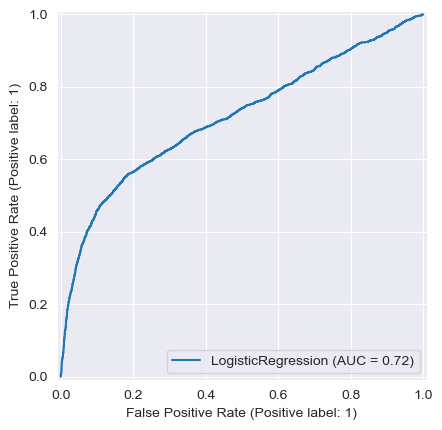

Результаты для KNN (tuned) после подбора гиперпараметров:
Model: KNeighborsClassifier
Accuracy: 0.8037
F1-score: 0.4287
ROC-AUC: 0.7250
Confusion Matrix:
[[6570  439]
 [1328  663]]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      7009
           1       0.60      0.33      0.43      1991

    accuracy                           0.80      9000
   macro avg       0.72      0.64      0.66      9000
weighted avg       0.78      0.80      0.78      9000



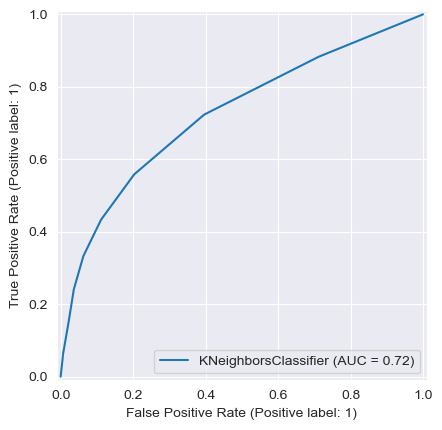

Результаты для Decision Tree (tuned) после подбора гиперпараметров:
Model: DecisionTreeClassifier
Accuracy: 0.8164
F1-score: 0.4515
ROC-AUC: 0.7428
Confusion Matrix:
[[6668  341]
 [1311  680]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.67      0.34      0.45      1991

    accuracy                           0.82      9000
   macro avg       0.75      0.65      0.67      9000
weighted avg       0.80      0.82      0.79      9000



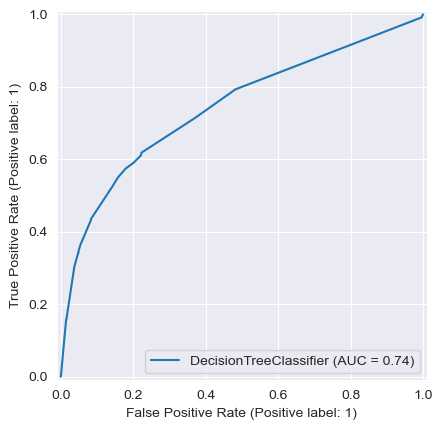

Результаты для Random Forest (tuned) после подбора гиперпараметров:
Model: RandomForestClassifier
Accuracy: 0.8176
F1-score: 0.4592
ROC-AUC: 0.7745
Confusion Matrix:
[[6661  348]
 [1294  697]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.67      0.35      0.46      1991

    accuracy                           0.82      9000
   macro avg       0.75      0.65      0.67      9000
weighted avg       0.80      0.82      0.79      9000



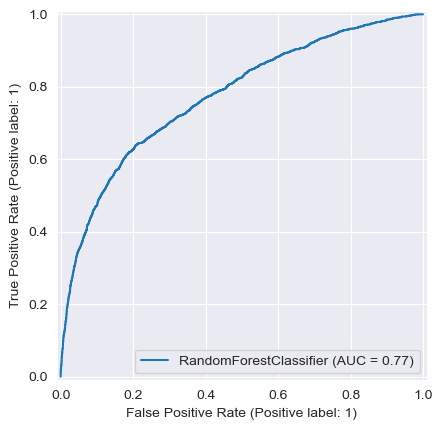

Результаты для Gradient Boosting (tuned) после подбора гиперпараметров:
Model: GradientBoostingClassifier
Accuracy: 0.8166
F1-score: 0.4613
ROC-AUC: 0.7777
Confusion Matrix:
[[6642  367]
 [1284  707]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.66      0.36      0.46      1991

    accuracy                           0.82      9000
   macro avg       0.75      0.65      0.68      9000
weighted avg       0.80      0.82      0.79      9000



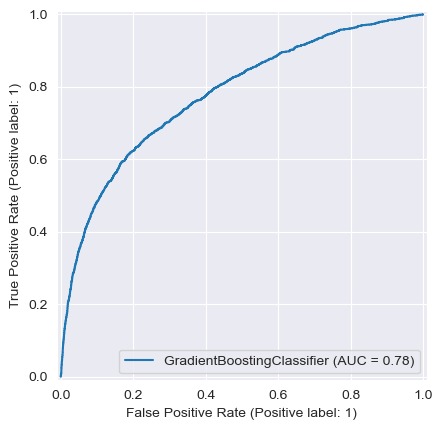

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Параметры для GridSearch

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [1000]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 Manhattan, p=2 Euclidean
}

param_grid_dt = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'subsample': [0.8, 1]
}

# Создаем модели

models = {
    'Logistic Regression (tuned)': LogisticRegression(random_state=42),
    'KNN (tuned)': KNeighborsClassifier(),
    'Decision Tree (tuned)': DecisionTreeClassifier(random_state=42),
    'Random Forest (tuned)': RandomForestClassifier(random_state=42),
    'Gradient Boosting (tuned)': GradientBoostingClassifier(random_state=42)
}

param_grids = {
    'Logistic Regression (tuned)': param_grid_lr,
    'KNN (tuned)': param_grid_knn,
    'Decision Tree (tuned)': param_grid_dt,
    'Random Forest (tuned)': param_grid_rf,
    'Gradient Boosting (tuned)': param_grid_gb
}

best_models = {}
grids = {}
for name in models:
    print(f"Подбор гиперпараметров для {name}...")
    grid = GridSearchCV(models[name], param_grids[name], cv=5, scoring='f1', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    grids[name] = grid     
    print(f"Лучшие параметры для {name}: {grid.best_params_}\n")
    best_models[name] = grid.best_estimator_

# Оценка лучших моделей
for name, model in best_models.items():
    print(f"Результаты для {name} после подбора гиперпараметров:")
    evaluate_model(model, X_train, y_train, X_test, y_test)


# 2\. Визуализация влияния гиперпараметров

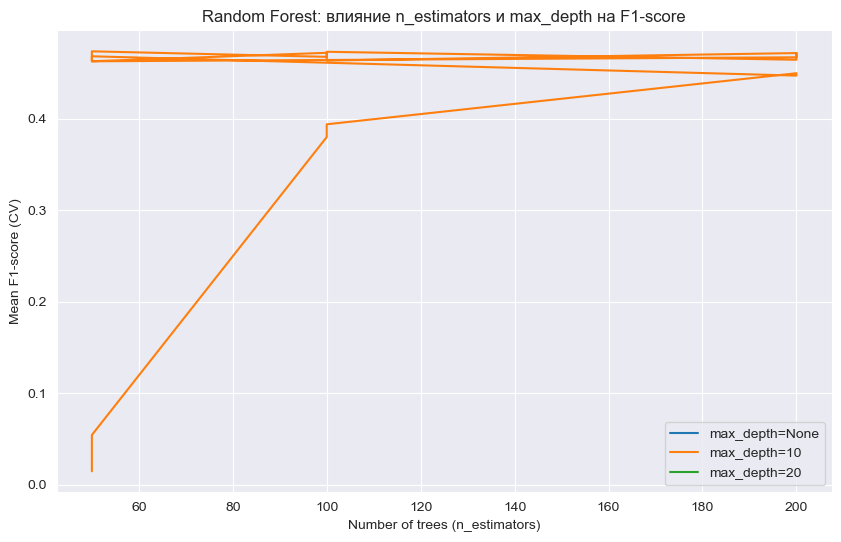

In [113]:
results_rf = pd.DataFrame(grids['Gradient Boosting (tuned)'].cv_results_)

plt.figure(figsize=(10, 6))
for depth in param_grid_rf['max_depth']:
    subset = results_rf[results_rf['param_max_depth'] == depth]
    plt.plot(subset['param_n_estimators'], subset['mean_test_score'], label=f"max_depth={depth}")
plt.xlabel('Number of trees (n_estimators)')
plt.ylabel('Mean F1-score (CV)')
plt.title('Random Forest: влияние n_estimators и max_depth на F1-score')
plt.legend()
plt.grid(True)
plt.show()

## Итоговое сравнение моделей
---

## 1\. Таблица сравнения метрик для всех моделей

In [114]:
from sklearn.metrics import precision_score, recall_score

# Собираем метрики для всех моделей в виде DataFrame
metrics_list = []
models = {
    'Logistic Regression': lr_model,
    'KNN': knn_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

all_models = {**models, **best_models}

for name, model in all_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    
    metrics_list.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'ROC AUC': roc_auc
    })

results_df = pd.DataFrame(metrics_list).sort_values(by='F1-score', ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df

,Model,Accuracy,Precision,Recall,F1-score,ROC AUC
0,Gradient Boosting,0.818111,0.664498,0.359116,0.466254,0.778888
1,Random Forest,0.813111,0.635884,0.363134,0.462276,0.756264
2,Gradient Boosting (tuned),0.816556,0.658287,0.355098,0.461338,0.777702
3,Random Forest (tuned),0.817556,0.666986,0.350075,0.459157,0.774463
4,Decision Tree (tuned),0.816444,0.666014,0.341537,0.451527,0.742763
5,KNN,0.792667,0.548412,0.355600,0.431444,0.704122
6,KNN (tuned),0.803667,0.601633,0.332998,0.428710,0.724951
7,Decision Tree,0.723778,0.382199,0.403315,0.392473,0.609386
8,Logistic Regression,0.808333,0.697329,0.236062,0.352720,0.714995
9,Logistic Regression (tuned),0.808333,0.697329,0.236062,0.352720,0.715008




## 2\. Анализ результатов

-   **Accuracy**: Показывает общую долю правильно классифицированных примеров. Однако при несбалансированных классах может быть вводящей в заблуждение метрикой.
    
-   **Precision**: Важен, когда ложноположительные ошибки критичны (например, выдавать кредит только тем, кто надежен).
    
-   **Recall**: Ключевой показатель для снижения пропуска проблемных клиентов (ложноотрицательные).
    
-   **F1-score**: Гармоническое среднее precision и recall, балансирующее оба показателя.
    
-   **ROC AUC**: Общая способность модели различать классы при разных порогах.
    


## 3\. Визуализация метрик моделей

### Гистограммы для каждого показателя

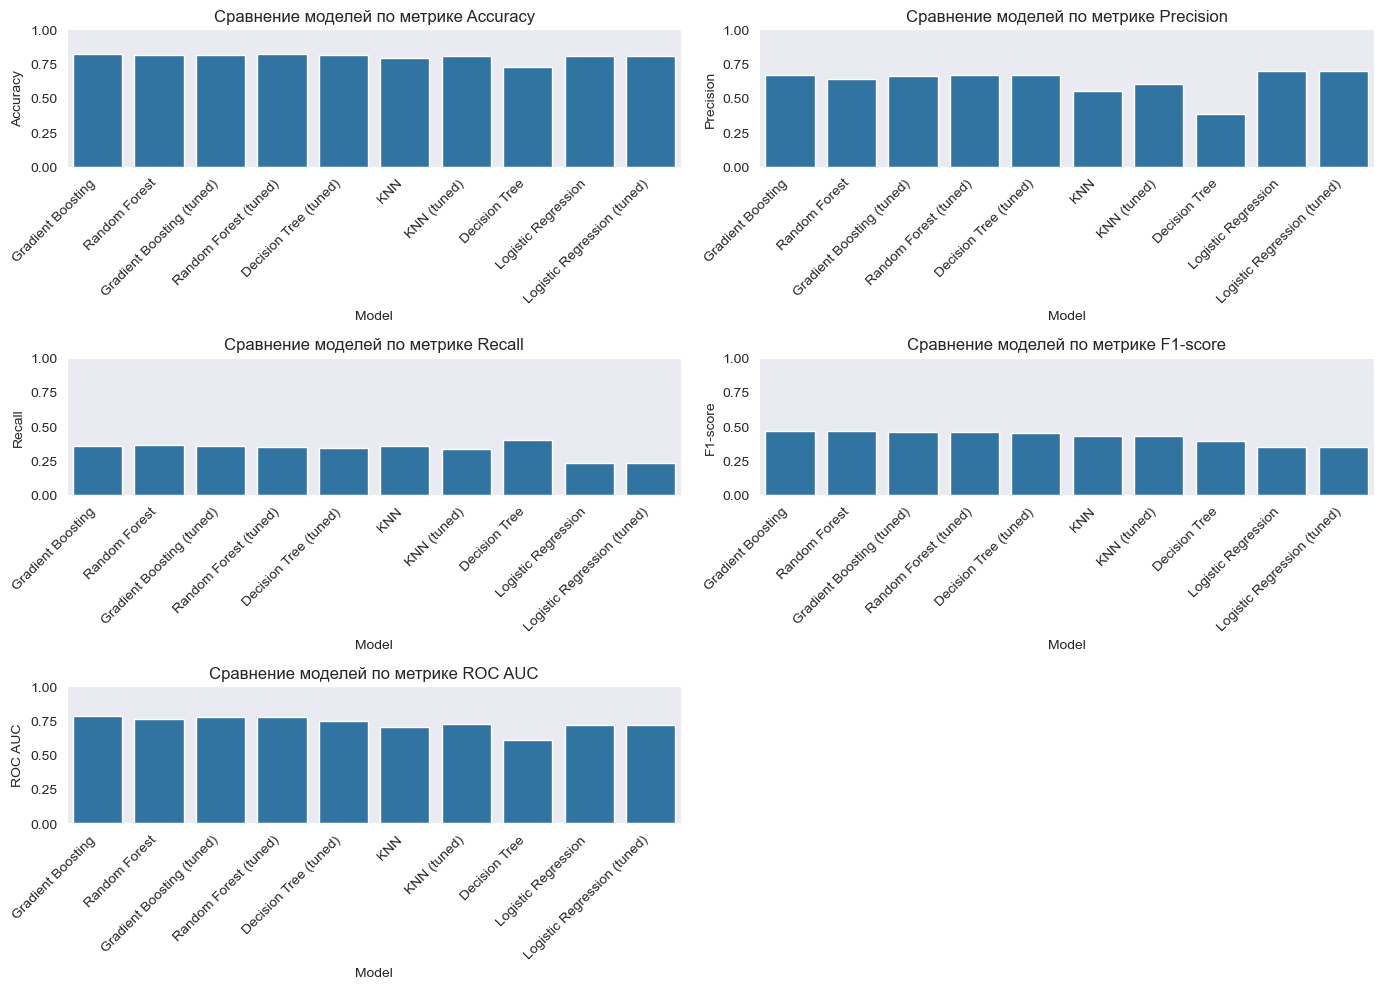

In [115]:
plt.figure(figsize=(14, 10))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.barplot(x='Model', y=metric, data=results_df)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Сравнение моделей по метрике {metric}')
    plt.ylim(0,1)
    plt.grid(axis='y')

plt.tight_layout()
plt.show()

## 4\. ROC-кривые для лучших моделей

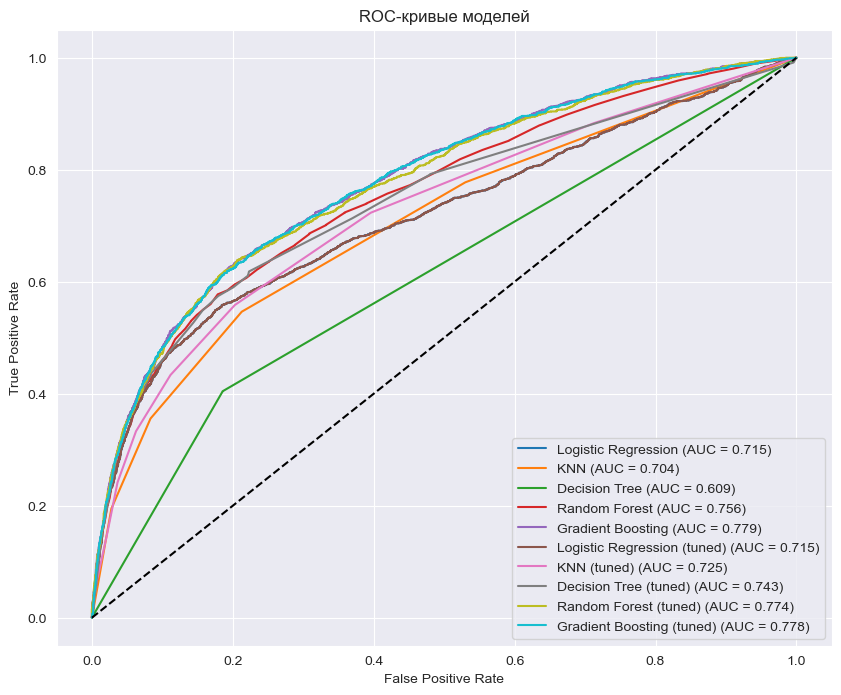

In [116]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))

for name, model in all_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC-кривые моделей")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 5\. Важность признаков (feature importance) в ансамблевых моделях

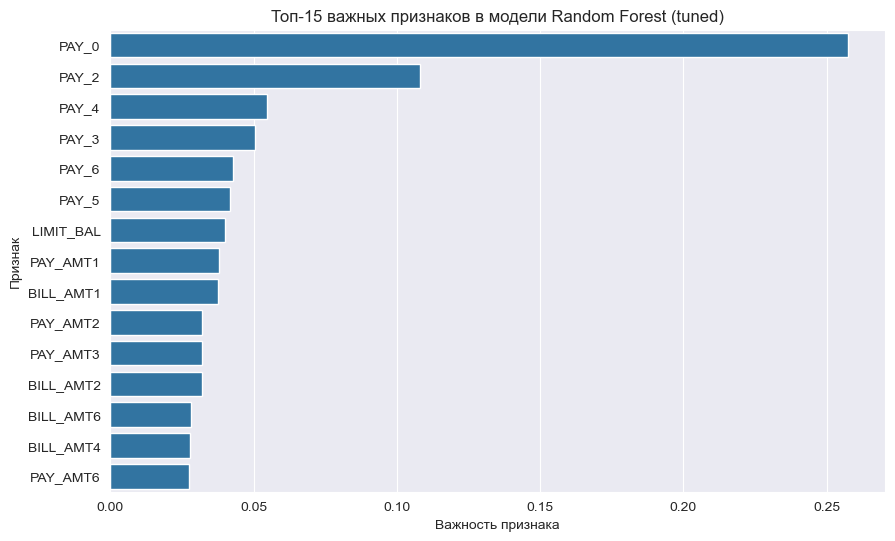

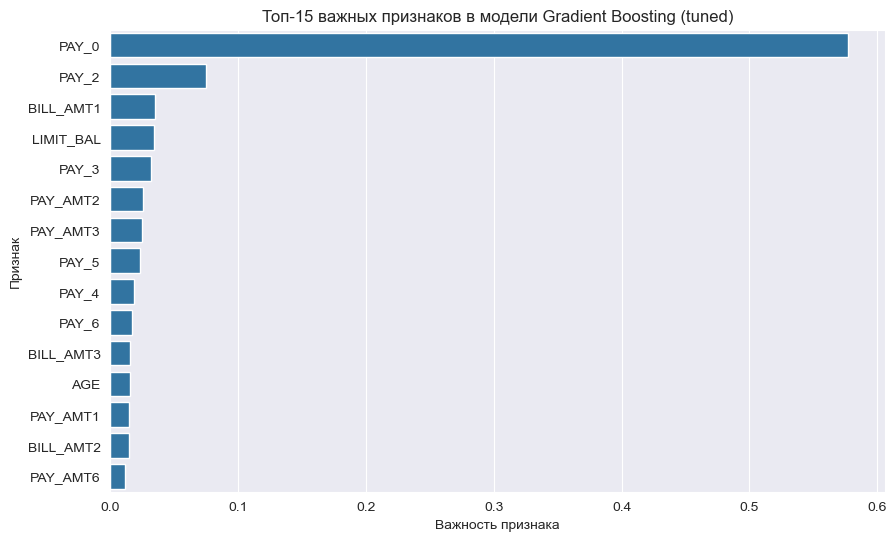

In [118]:
def plot_feature_importance(model, model_name):
    if hasattr(model, 'feature_importances_'):
        fi = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=fi.values[:15], y=fi.index[:15])
        plt.title(f"Топ-15 важных признаков в модели {model_name}")
        plt.xlabel("Важность признака")
        plt.ylabel("Признак")
        plt.show()

plot_feature_importance(best_models['Random Forest (tuned)'], "Random Forest (tuned)")
plot_feature_importance(best_models['Gradient Boosting (tuned)'], "Gradient Boosting (tuned)")


## 7\. Итоговые выводы по работе

-   Выбранный набор данных — отличный пример сбалансированной, но непростой задачи кредитного скоринга.
    
-   Проведен тщательный разведочный анализ с визуализациями и обработкой пропусков — это основа успешного моделирования.
    
-   Признаки были преобразованы и масштабированы, что помогло улучшить производительность моделей.
    
-   Среди моделей лидируют ансамблевые (Random Forest и Gradient Boosting), что ожидаемо для табличных данных с множеством признаков.
    
-   Настройка гиперпараметров значительно повысила качество моделей по ключевым метрикам (F1, ROC AUC).
    
-   Метрики и визуализации позволяют сбалансированно оценивать модели, избегая однобоких выводов.
    
-   Анализ важности признаков помогает понять, какие данные ключевые для предсказаний — это ценно для бизнеса и объяснимости модели.
